### Collect relevant paths

In [25]:
import re
import glob
from aicsimageio import AICSImage
import numpy as np
import cv2
from scipy import ndimage
from PIL import Image
import os
import re
from natsort import natsorted
import matplotlib.pyplot as plt
from skimage import io, img_as_float32, transform
from sklearn.model_selection import train_test_split

seed = 33
split_ratio = 0.8
np.random.seed(seed)
target_num_layers = 6  # Target number of layers for interpolation

In [26]:
datasets_to_augment = ["Study_3", "Study_4_1", "Study_4_2", "Study_5", "Study_6", "Study_7", "Study_17_1", "Study_17_2", 
                       "Study_17_3", "Study_17_4", "Study_17_5", "Study_17_6", "Study_20", "Study_21", "Study_24", "Study_29_1", "Study_29_2", "Study_29_3",
                       "Study_29_4",  "Study_30"]       #Studies with Actin and Tubulin

In [27]:
path = '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/'
img_files = glob.glob(path + '*z*')
ch1_files = glob.glob(path + '*Nuc*')
ch2_files = glob.glob(path + '*Mito*')
ch3_files = glob.glob(path + '*Actin*')
ch4_files = glob.glob(path + '*Tub*')

In [28]:
#def tile_image(image, patch_size=(256, 256), overlap=(0, 0)):
#    if image is None:
#        print("Error: Input image is None")
#        return
#
#    if len(image.shape) != 3:
#        print("Error: Input image should be a 3-dimensional array (height x width x channels)")
#        return
#        
#    height, width = image.shape[-2:]
#    patch_height, patch_width = patch_size
#    overlap_height, overlap_width = overlap

#    patches = []

#    # Calculate the number of patches in both dimensions
#    num_patches_height = (height - overlap_height) // (patch_height - overlap_height) + 1
#    num_patches_width = (width - overlap_width) // (patch_width - overlap_width) + 1

#    # Iterate over each patch position
#    for i in range(num_patches_height):
#        for j in range(num_patches_width):
#            # Calculate patch start and end positions
            
            
#            start_h = i * (patch_height - overlap_height)
#            end_h = min(start_h + patch_height, height)
#            if(end_h - start_h < 256):
#                start_h = (end_h - 256)
            
            
#            start_w = j * (patch_width - overlap_width)
#            end_w = min(start_w + patch_width, width)
#            if(end_w - start_w < 256):
#                start_w = (end_w - 256)
            

#            # Extract the patch
#            patch = image[:,start_h:end_h, start_w:end_w]

#            # Append the patch to the list
#            patches.append(patch)

#    return patches

In [29]:
def natural_sort_key(s):
    """Key function for natural sorting."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def min_max_normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    return normalized_image
    
def z_score_normalize(image):
    mean_val = np.mean(image)
    std_val = np.std(image)
    normalized_image = (image - mean_val) / std_val
    return normalized_image

def percentile_normalization(image, pmin=2, pmax=99.8, axis=None, dtype=np.uint16 ):
    '''
    Compute a percentile normalization for the given image.

    Parameters:
    - image (array): array of the image file.
    - pmin  (int or float): the minimal percentage for the percentiles to compute. 
                            Values must be between 0 and 100 inclusive.
    - pmax  (int or float): the maximal percentage for the percentiles to compute. 
                            Values must be between 0 and 100 inclusive.
    - axis : Axis or axes along which the percentiles are computed. 
             The default (=None) is to compute it along a flattened version of the array.
    - dtype (dtype): type of the wanted percentiles (uint16 by default)

    Returns:
    Normalized image (np.ndarray): An array containing the normalized image.
    '''

    if not (np.isscalar(pmin) and np.isscalar(pmax) and 0 <= pmin < pmax <= 100 ):
        raise ValueError("Invalid values for pmin and pmax")

    low_p  = np.percentile(image, pmin, axis=axis, keepdims=True)
    high_p = np.percentile(image, pmax, axis=axis, keepdims=True)

    if low_p == high_p:
        img_norm = image
        print(f"Same min {low_p} and high {high_p}, image may be empty")

    else:
        dtype_max = np.iinfo(dtype).max
        img_norm = dtype_max * (image - low_p) / (high_p - low_p)
        img_norm = img_norm.astype(dtype)

    return img_norm

In [30]:
def combine_layers(stack, target_num_layers):
    num_layers = stack.shape[0]
    if num_layers == target_num_layers:
        return stack
    
    # Calculate interpolation factor
    interpolation_factor = target_num_layers / num_layers        # look up interpolation exactly, what order?
    
    # Interpolate along the depth axis
    combined_stack = ndimage.zoom(stack, (interpolation_factor, 1, 1), order=3)
    
    return combined_stack

In [31]:
img_files = sorted(img_files, key=natural_sort_key)
ch1_files = sorted(ch1_files, key=natural_sort_key)
ch2_files = sorted(ch2_files, key=natural_sort_key)
ch3_files = sorted(ch3_files, key=natural_sort_key)
ch4_files = sorted(ch4_files, key=natural_sort_key)

In [32]:
for file in img_files:
    print(file)

/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z0.ome.tiff
/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z1.ome.tiff
/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z2.ome.tiff
/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z3.ome.tiff
/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z4.ome.tiff
/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z5.ome.tiff
/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z6.ome.tiff
/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z7.ome.tiff
/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z8.ome.tiff
/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z9.ome.tiff
/media/local-admin/galaxy/ligh

In [33]:
print(f"Image files: {len(img_files)}")
print(f"Nuc files: {len(ch1_files)}")
print(f"Mito files: {len(ch2_files)}")
print(f"Actin files: {len(ch3_files)}")
print(f"Tub files: {len(ch4_files)}")

Image files: 125
Nuc files: 10
Mito files: 10
Actin files: 0
Tub files: 0


### Identify missing targets from channels

In [34]:
channel_lists = [ch1_files, ch2_files, ch3_files, ch4_files]  

In [35]:
all_channels = []

for channel in channel_lists:
    all_channels.extend(channel)

In [36]:
all_channels

['/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_Nucleus.ome.tiff',
 '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_44_Nucleus.ome.tiff',
 '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_45_Nucleus.ome.tiff',
 '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_46_Nucleus.ome.tiff',
 '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_47_Nucleus.ome.tiff',
 '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_48_Nucleus.ome.tiff',
 '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_49_Nucleus.ome.tiff',
 '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_50_Nucleus.ome.tiff',
 '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_51_Nucleus.ome.tiff',
 '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_52

In [37]:
# Example list of image filenames
target_filenames = all_channels

# Regular expression pattern to match 'image_xy'
pattern = r"image_\d+"

# Extract unique 'image_xy' identifiers
unique_target_identifiers = natsorted(set(re.findall(pattern, ' '.join(target_filenames))))

max_target_count = len(unique_target_identifiers)

# Print unique 'image_xy' identifiers
print("Unique target identifiers:")
for identifier in unique_target_identifiers:
    print(identifier)
print(max_target_count)

Unique target identifiers:
image_43
image_44
image_45
image_46
image_47
image_48
image_49
image_50
image_51
image_52
10


In [38]:
channel_names = ['Nuc', 'Mito', 'Actin', 'Tub']
missing_index_dict = {}

for i,channel in enumerate(channel_lists):
    if len(channel) < max_target_count:
        # Example list of image filenames
        image_filenames = img_files
    
        # Example list of target filenames
        target_filenames = channel
        
        # Regular expression pattern to match 'image_xy'
        pattern = r"image_\d+"
        
        # Extract unique 'image_xy' identifiers from image filenames
        unique_image_identifiers = set(re.findall(pattern, ' '.join(image_filenames)))
        
        # Extract 'image_xy' identifiers from target filenames
        target_image_identifiers = set(re.findall(pattern, ' '.join(target_filenames)))
        
        # List to store identifiers not present in target filenames
        missing_identifiers = []
        
        # Check if unique 'image_xy' identifiers are present in target filenames
        for identifier in unique_image_identifiers:
            if identifier not in target_image_identifiers:
                missing_identifiers.append(identifier)
        
        print(f"Identifiers not present in target filenames for {channel_names[i]}:", missing_identifiers)
        print(f"Number of missing items: {len(missing_identifiers)}")
    
        missing_indexes = []
        #for identifier in missing_identifiers:
        for item in missing_identifiers:
            index_of_missing = unique_target_identifiers.index(item)
            missing_indexes.append(index_of_missing)
            print(f'Index of missing item: {index_of_missing}')
        missing_index_dict[channel_names[i]] = sorted(missing_indexes)

Identifiers not present in target filenames for Actin: ['image_47', 'image_51', 'image_43', 'image_52', 'image_48', 'image_49', 'image_44', 'image_50', 'image_46', 'image_45']
Number of missing items: 10
Index of missing item: 4
Index of missing item: 8
Index of missing item: 0
Index of missing item: 9
Index of missing item: 5
Index of missing item: 6
Index of missing item: 1
Index of missing item: 7
Index of missing item: 3
Index of missing item: 2
Identifiers not present in target filenames for Tub: ['image_47', 'image_51', 'image_43', 'image_52', 'image_48', 'image_49', 'image_44', 'image_50', 'image_46', 'image_45']
Number of missing items: 10
Index of missing item: 4
Index of missing item: 8
Index of missing item: 0
Index of missing item: 9
Index of missing item: 5
Index of missing item: 6
Index of missing item: 1
Index of missing item: 7
Index of missing item: 3
Index of missing item: 2


In [39]:
missing_index_dict

{'Actin': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'Tub': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

### Collecting images

In [40]:
#for file in img_files:
    #img = AICSImage(file)
    #img_array = img.data
    #print(img_array.shape)

In [41]:
#unique_shapes = set()

#for file in img_files:
#    img = AICSImage(file)
#    img_array = img.data
#    shape = img_array.shape
#    unique_shapes.add(shape)

## Print the unique shapes
#for shape in unique_shapes:
    #print(shape)

In [42]:
# Dictionary to store filenames organized by image number
image_number_dict = {}

# Regular expression pattern to extract image numbers
pattern = r'image_(\d+)_\w+_z\d+\.ome\.tiff'

for filename in img_files:
    # Extract image number from filename
    match = re.search(pattern, filename)
    if match:
        image_number = int(match.group(1))
        # Add filename to the corresponding list based on image number
        if image_number in image_number_dict:
            image_number_dict[image_number].append(filename)
        else:
            image_number_dict[image_number] = [filename]

In [43]:
image_number_dict

{43: ['/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z0.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z1.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z2.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z3.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z4.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z5.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z6.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z7.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z8.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/ima

In [44]:
# Regular expression pattern to extract image numbers
#pattern = r'image_(\d+)_\w+.ome\.tiff'

#for channel in channel_lists:
#    for filename in channel:
#        # Extract image number from filename
#        match = re.search(pattern, filename)
#        if match:
#            image_number = int(match.group(1))
#            # Add filename to the corresponding list based on image number
#            if image_number in image_number_dict:
#                image_number_dict[image_number].append(filename)
#            else:
#                image_number_dict[image_number] = [filename]

In [45]:
# Iterate through the dictionary and print the number of items for each key
num_layers = []
for key, value in image_number_dict.items():
    num_layers.append(len(value))
    print(f"Number of items assigned to key {key}: {len(value)}")

Number of items assigned to key 43: 12
Number of items assigned to key 44: 11
Number of items assigned to key 45: 9
Number of items assigned to key 46: 14
Number of items assigned to key 47: 12
Number of items assigned to key 48: 17
Number of items assigned to key 49: 15
Number of items assigned to key 50: 13
Number of items assigned to key 51: 12
Number of items assigned to key 52: 10


In [46]:
image_number_dict

{43: ['/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z0.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z1.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z2.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z3.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z4.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z5.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z6.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z7.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/image_43_DIC_z8.ome.tiff',
  '/media/local-admin/galaxy/lightmycells_storage/images/Study_DIC/Study_2/ima

In [47]:
img_data = []
max_layers = 0
for image_number, filenames in image_number_dict.items():
    # Initialize an empty list to store image arrays for the current image number
    image_arrays = []
    
    # Iterate through the list of filenames for the current image number
    for filename in filenames:
        # Load image data using AICSImage
        img = AICSImage(filename)
        img_array = img.data
        #img_array = img_as_float32(img_array)
        img_array = np.squeeze(img_array)
        #img_array = cv2.resize(img_array, dsize=(resize_size[1], resize_size[0]), interpolation=cv2.INTER_CUBIC)
        #img_array = min_max_normalize(img_array)
        #img_array = z_score_normalize(img_array)
        #img_array = percentile_normalization(img_array)     !!!
        img_array = np.squeeze(img_array)
        # Append the image array to the list of image arrays for the current image number
        image_arrays.append(img_array)
        
    # Stack the image arrays along a new dimension to create a numpy array
    image_arrays_stacked = np.stack(image_arrays, axis=0)
    #image_arrays_stacked = np.squeeze(image_arrays_stacked)
    
    #print(image_arrays_stacked.shape)
    if image_arrays_stacked.shape[0] > max_layers:
        max_layers = image_arrays_stacked.shape[0]
    
    img_data.append(image_arrays_stacked)

In [48]:
#Interpolation
for i,stack in enumerate(img_data):
    img_data[i] = combine_layers(img_data[i], target_num_layers)

In [49]:
img_array = np.array(img_data)
#img_array = np.expand_dims(img_array, axis=1)

In [50]:
img_array.shape

(10, 6, 1024, 1024)

In [51]:
img_array.dtype

dtype('uint16')

In [52]:
len(img_array)

10

### Adding blank targets if they are missing

In [53]:
mask_stacks = []                                               #This is so if targets are missing, blanks are added in their place

for i,channel in enumerate(channel_lists):
    
    channel_list = []
    for mask in channel:
        mask_img = AICSImage(mask)
        mask_array = mask_img.data
        #mask_array = img_as_float32(mask_array)
        print(mask_array.dtype)
        #mask_array = np.squeeze(img_array)
        mask_array = np.squeeze(mask_array)
        #mask_array = cv2.resize(mask_array, dsize=resize_size)
        #mask_array = min_max_normalize(mask_array)                                     #change to float32, 
        #mask_array = z_score_normalize(mask_array)
        #mask_array = percentile_normalization(mask_array)
        channel_list.append(mask_array) 

    if channel_names[i] in missing_index_dict:
        #print(channel_names[i])
        # Get the indexes from the dictionary corresponding to the appropriate key
        zeros_array = np.zeros(img_array[0][0].shape).astype(np.uint16)                                         #!!!!!!!!!!!!!!!!!!!!!
        mito_indexes = missing_index_dict.get(channel_names[i], [])
        #print(mito_indexes)

        # Insert zeros_array at the indexes specified by mito_indexes in ch1_list
        for idx in mito_indexes:
            channel_list.insert(idx, zeros_array)
        
    mask_stacks.append(channel_list)

uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16
uint16


In [54]:
missing_index_dict

{'Actin': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'Tub': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [55]:
for channel in mask_stacks:
    for i,x in enumerate(channel):
        if x.all() == 0:
            print(f'{i}: Replaced with blank')
    print(' ')

0: Replaced with blank
1: Replaced with blank
2: Replaced with blank
3: Replaced with blank
4: Replaced with blank
5: Replaced with blank
6: Replaced with blank
7: Replaced with blank
8: Replaced with blank
9: Replaced with blank
 
0: Replaced with blank
1: Replaced with blank
2: Replaced with blank
3: Replaced with blank
4: Replaced with blank
5: Replaced with blank
6: Replaced with blank
7: Replaced with blank
8: Replaced with blank
9: Replaced with blank
 
0: Replaced with blank
1: Replaced with blank
2: Replaced with blank
3: Replaced with blank
4: Replaced with blank
5: Replaced with blank
6: Replaced with blank
7: Replaced with blank
8: Replaced with blank
9: Replaced with blank
 
0: Replaced with blank
1: Replaced with blank
2: Replaced with blank
3: Replaced with blank
4: Replaced with blank
5: Replaced with blank
6: Replaced with blank
7: Replaced with blank
8: Replaced with blank
9: Replaced with blank
 


In [56]:
mask_data = np.array(mask_stacks)

In [57]:
mask_data.dtype

dtype('uint16')

In [58]:
mask_data = np.swapaxes(mask_data, 0,1)

In [59]:
mask_data.dtype

dtype('uint16')

In [60]:
mask_data.shape

(10, 4, 1024, 1024)

In [61]:
img_data = img_array

In [62]:
img_data[0].shape

(6, 1024, 1024)

In [63]:
mask_data[0].shape

(4, 1024, 1024)

In [64]:
mask_data.shape

(10, 4, 1024, 1024)

In [65]:
mask_data.dtype

dtype('uint16')

In [66]:
img_data.dtype

dtype('uint16')

In [67]:
img_data.dtype

dtype('uint16')

In [68]:
mask_data.dtype

dtype('uint16')

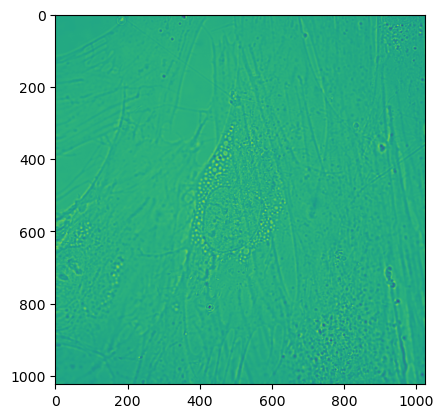

In [69]:
plt.imshow(img_data[0][0])

### Shuffle the "stacks" so it's not always the last x% that gets split off (while respecting the stacks)

In [46]:
# Initialize lists to store the split data
split_img_data = []
split_mask_data = []

# Iterate over num_layers to split img_data and mask_data
start_idx = 0
for num in num_layers:
    end_idx = start_idx + num
    split_img_data.append(img_data[start_idx:end_idx])
    split_mask_data.append(mask_data[start_idx:end_idx])
    start_idx = end_idx

# Verify the split data
print("Data split according to stacks before shuffling:")
for i, (img, mask) in enumerate(zip(split_img_data, split_mask_data)):
    print(f"Stack {i+1}: Image data shape: {img.shape}, Mask data shape: {mask.shape}, Num layers: {num_layers[i]}")


Data split according to stacks before shuffling:
Stack 1: Image data shape: (10, 6, 1024, 1024), Mask data shape: (10, 4, 1024, 1024), Num layers: 12
Stack 2: Image data shape: (0, 6, 1024, 1024), Mask data shape: (0, 4, 1024, 1024), Num layers: 11
Stack 3: Image data shape: (0, 6, 1024, 1024), Mask data shape: (0, 4, 1024, 1024), Num layers: 9
Stack 4: Image data shape: (0, 6, 1024, 1024), Mask data shape: (0, 4, 1024, 1024), Num layers: 14
Stack 5: Image data shape: (0, 6, 1024, 1024), Mask data shape: (0, 4, 1024, 1024), Num layers: 12
Stack 6: Image data shape: (0, 6, 1024, 1024), Mask data shape: (0, 4, 1024, 1024), Num layers: 17
Stack 7: Image data shape: (0, 6, 1024, 1024), Mask data shape: (0, 4, 1024, 1024), Num layers: 15
Stack 8: Image data shape: (0, 6, 1024, 1024), Mask data shape: (0, 4, 1024, 1024), Num layers: 13
Stack 9: Image data shape: (0, 6, 1024, 1024), Mask data shape: (0, 4, 1024, 1024), Num layers: 12
Stack 10: Image data shape: (0, 6, 1024, 1024), Mask data s

In [47]:
 #Shuffle the data
shuffled_indices = np.random.permutation(len(img_data))
shuffled_img_data = [img_data[i] for i in shuffled_indices]
shuffled_mask_data = [mask_data[i] for i in shuffled_indices]
shuffled_num_layers = [num_layers[i] for i in shuffled_indices]

# Verify the shuffled data
print("Data split according to stacks after shuffling:")
for i, (img, mask) in enumerate(zip(shuffled_img_data, shuffled_mask_data)):
    print(f"Stack {i+1}: Image data shape: {img.shape}, Mask data shape: {mask.shape}, Num layers originally: {shuffled_num_layers[i]}")


Data split according to stacks after shuffling:
Stack 1: Image data shape: (6, 1024, 1024), Mask data shape: (4, 1024, 1024), Num layers originally: 12
Stack 2: Image data shape: (6, 1024, 1024), Mask data shape: (4, 1024, 1024), Num layers originally: 14
Stack 3: Image data shape: (6, 1024, 1024), Mask data shape: (4, 1024, 1024), Num layers originally: 17
Stack 4: Image data shape: (6, 1024, 1024), Mask data shape: (4, 1024, 1024), Num layers originally: 10
Stack 5: Image data shape: (6, 1024, 1024), Mask data shape: (4, 1024, 1024), Num layers originally: 11
Stack 6: Image data shape: (6, 1024, 1024), Mask data shape: (4, 1024, 1024), Num layers originally: 15
Stack 7: Image data shape: (6, 1024, 1024), Mask data shape: (4, 1024, 1024), Num layers originally: 9
Stack 8: Image data shape: (6, 1024, 1024), Mask data shape: (4, 1024, 1024), Num layers originally: 12
Stack 9: Image data shape: (6, 1024, 1024), Mask data shape: (4, 1024, 1024), Num layers originally: 13
Stack 10: Image d

In [48]:
# Verify the shape of the reunited shuffled data
reunited_shuffled_img_data = np.array(shuffled_img_data)
reunited_shuffled_mask_data = np.array(shuffled_mask_data)

print("Reunited Shuffled Image Data Shape:", reunited_shuffled_img_data.shape)
print("Reunited Shuffled Mask Data Shape:", reunited_shuffled_mask_data.shape)

img_data = reunited_shuffled_img_data
mask_data = reunited_shuffled_mask_data
num_layers = shuffled_num_layers

Reunited Shuffled Image Data Shape: (10, 6, 1024, 1024)
Reunited Shuffled Mask Data Shape: (10, 4, 1024, 1024)


In [49]:
img_data.dtype

dtype('uint16')

In [50]:
mask_data.dtype

dtype('uint16')

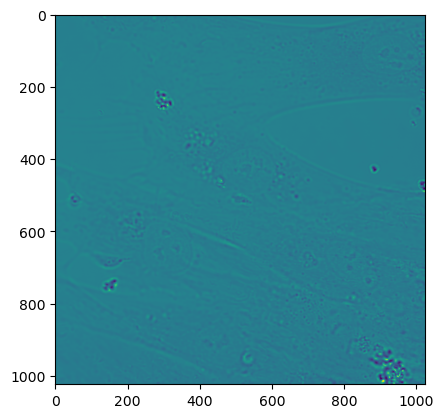

In [51]:
plt.imshow(img_data[0][0])

### Split into train, valid, test

#### Split train and test_t

In [52]:
# Calculate the split indices
index = int(len(img_data) * split_ratio)  # Assuming 80% training and 20% testing, change this if you have more data

# Split the data into training and testing sets
train_data = img_data[:index]
train_targets = mask_data[:index]
test_data_t = img_data[index:]
test_targets_t = mask_data[index:]

# Print the shapes of the resulting datasets
print("Index:", index)
print("Training Image Data Shape:", train_data.shape)
print("Training Mask Data Shape:", train_targets.shape)
print("Testing Image Data Shape:", test_data_t.shape)
print("Testing Mask Data Shape:", test_targets_t.shape)

Index: 8
Training Image Data Shape: (8, 6, 1024, 1024)
Training Mask Data Shape: (8, 4, 1024, 1024)
Testing Image Data Shape: (2, 6, 1024, 1024)
Testing Mask Data Shape: (2, 4, 1024, 1024)


In [53]:
train_data.dtype

dtype('uint16')

In [54]:
train_targets.dtype

dtype('uint16')

In [55]:
test_data_t.dtype

dtype('uint16')

In [56]:
test_targets_t.dtype

dtype('uint16')

#### Split into test and valid

In [57]:
#num_layers_test = num_layers[stack_index+1:]

In [58]:
#num_layers_test

In [59]:
#num_stacks_test = len(num_layers_test)

# Accumulate the count of images in each stack
#stack_indices_test = np.cumsum(num_layers_test)

# Total number of images
#total_images_test = sum(num_layers_test)

# Calculate the split indices
index_test = int(len(test_data_t) * 0.5)  # Assuming 80% training and 20% testing

# Find the stack index at which the split occurs
#stack_index_test = np.argmax(stack_indices_test >= split_index_test)
    
#index_test = stack_indices_test[stack_index_test]
print(index_test)

# Split the data into valid and testing sets
validation_data = test_data_t[:index_test]
validation_targets = test_targets_t[:index_test]
test_data = test_data_t[index_test:]
test_targets = test_targets_t[index_test:]

# Print the shapes of the resulting datasets
print("Valid Image Data Shape:", validation_data.shape)
print("Valid Mask Data Shape:", validation_targets.shape)
print("Test Image Data Shape:", test_data.shape)
print("Test Mask Data Shape:", test_targets.shape)

1
Valid Image Data Shape: (1, 6, 1024, 1024)
Valid Mask Data Shape: (1, 4, 1024, 1024)
Test Image Data Shape: (1, 6, 1024, 1024)
Test Mask Data Shape: (1, 4, 1024, 1024)


In [60]:
## Iterate through each image in train_targets
#for train_image_idx, train_image in enumerate(train_targets):
#    # Iterate through each image in test_targets_t
#    for test_image_idx, test_image in enumerate(test_targets):
#        # Check if the current train image is identical to the current test image
#        if np.array_equal(train_image, test_image):
#            print(f"Duplicate found! Train image index: {train_image_idx}, Test image index: {test_image_idx}")

In [61]:
validation_data.dtype

dtype('uint16')

In [62]:
validation_targets.dtype

dtype('uint16')

In [63]:
test_data.dtype

dtype('uint16')

In [64]:
test_targets.dtype

dtype('uint16')

### Resizing

In [65]:
resize_size = (1024, 1024)

In [66]:
train_data.shape

(8, 6, 1024, 1024)

In [67]:
resized_train_data = []

# Iterate through each image in the train_data
for img in train_data:
    resized_slices = []
    # img is currently of shape (C, 1200, 1200)
    for slice_idx in range(img.shape[0]):
        # Resize each slice individually
        img_slice_resized = cv2.resize(img[slice_idx], dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
        resized_slices.append(img_slice_resized)
    
    # Stack the resized slices along the first dimension
    img_resized = np.stack(resized_slices, axis=0)

    # Append the resized image to the new array
    resized_train_data.append(img_resized)

# Convert the list to a numpy array
resized_train_data = np.array(resized_train_data)

# Verify the shape
print(resized_train_data.shape)


(8, 6, 1024, 1024)


In [68]:
resized_train_targets = []

# Iterate through each mask in the train_targets
for mask in train_targets:
    resized_slices = []
    # mask is currently of shape (C, 1200, 1200)
    for slice_idx in range(mask.shape[0]):
        # Resize each slice individually
        mask_slice_resized = cv2.resize(mask[slice_idx], dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
        resized_slices.append(mask_slice_resized)
    
    # Stack the resized slices along the first dimension
    mask_resized = np.stack(resized_slices, axis=0)

    # Append the resized mask to the new array
    resized_train_targets.append(mask_resized)

# Convert the list to a numpy array
resized_train_targets = np.array(resized_train_targets)

# Verify the shape
print(resized_train_targets.shape)

(8, 4, 1024, 1024)


In [69]:
resized_valid_data = []
resized_valid_targets = []

# Iterate through each image and mask in the valid_data and valid_targets
for img, mask in zip(validation_data, validation_targets):
    # Resize the image
    resized_img_slices = []
    for slice_idx in range(img.shape[0]):
        img_slice_resized = cv2.resize(img[slice_idx], dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
        resized_img_slices.append(img_slice_resized)
    img_resized = np.stack(resized_img_slices, axis=0)
    resized_valid_data.append(img_resized)
    
    # Resize the mask
    resized_mask_slices = []
    for slice_idx in range(mask.shape[0]):
        mask_slice_resized = cv2.resize(mask[slice_idx], dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
        resized_mask_slices.append(mask_slice_resized)
    mask_resized = np.stack(resized_mask_slices, axis=0)
    resized_valid_targets.append(mask_resized)

# Convert the lists to numpy arrays
resized_valid_data = np.array(resized_valid_data)
resized_valid_targets = np.array(resized_valid_targets)

# Verify the shapes
print(resized_valid_data.shape)
print(resized_valid_targets.shape)

(1, 6, 1024, 1024)
(1, 4, 1024, 1024)


In [70]:
train_data = resized_train_data 
train_targets = resized_train_targets
validation_data = resized_valid_data
validation_targets =resized_valid_targets

In [71]:
#from sklearn.model_selection import train_test_split

In [72]:
#train_data_t, test_data, train_targets_t, test_targets = train_test_split(img_data, mask_data, test_size=0.05)

In [73]:
#train_data_t.shape

In [74]:
#train_targets_t.shape

In [75]:
#test_data.shape

In [76]:
#test_targets.shape

### Data augmentation

In [77]:
def augment_images(train_images, target_images, augmentation_percentage=0.3):
    augmented_train_images = []
    augmented_target_images = []
    num_images_to_augment = int(len(train_images) * augmentation_percentage)
    indices_to_augment = np.random.choice(len(train_images), size=num_images_to_augment, replace=False)
    
    for idx, (train_img, target_img) in enumerate(zip(train_images, target_images)):
        if idx in indices_to_augment:
            augmented_train_img = train_img.copy()
            augmented_target_img = target_img.copy()
            random_var = np.random.rand()
            noise = np.random.normal(loc=0, scale=1, size=augmented_train_img[0].shape).astype(np.uint16)
            print(type(noise))
            print(augmented_train_img.dtype)
            print(augmented_target_img.dtype)
            
            for layer in range(augmented_train_img.shape[0]):                             
                # Apply flipping & noise
                if random_var <= 0.2:
                    augmented_train_img[layer] = np.flipud(augmented_train_img[layer])      # All of them will never happen together, right?
                elif 0.2 <= random_var <= 0.8:
                   augmented_train_img[layer] = np.clip(augmented_train_img[layer] + noise, 0, 65535)
                else:
                    augmented_train_img[layer] = np.fliplr(augmented_train_img[layer])       

            augmented_train_images.append(augmented_train_img)
            
            for layer in range(augmented_target_img.shape[0]):
                if np.all(augmented_target_img[layer] == 0):
                    continue
                    
                elif random_var <= 0.2:
                    augmented_target_img[layer] = np.flipud(augmented_target_img[layer])
                elif 0.2 <= random_var <= 0.8:
                    augmented_target_img[layer] = np.clip(augmented_target_img[layer] + noise, 0, 65535)
                else:
                    augmented_target_img[layer] = np.fliplr(augmented_target_img[layer])
                 
            augmented_target_images.append(augmented_target_img)

            print(augmented_train_img.dtype)
            print(augmented_target_img.dtype)

        
        
        augmented_train_images.append(train_img)          # keep the originals too
        augmented_target_images.append(target_img)
        print(train_img.dtype)
        print(target_img.dtype)
        
        
    
    return np.array(augmented_train_images), np.array(augmented_target_images)

In [78]:
present_tub = 0                             #In study_DIC_110, tubulin is only present in 3 datasets, so I want to augment those
for target in train_targets:
    if np.any(target[3] != 0):
        present_tub += 1
print(f"Number of masks with tubulin before agumentation: {present_tub}")

Number of masks with tubulin before agumentation: 0


In [79]:
augmented_train_data = train_data
augmented_target_data = train_targets
for dataset in datasets_to_augment:
    if dataset in path:
        augmented_train_data, augmented_target_data = augment_images(train_data, train_targets, augmentation_percentage=0.5)
        break

In [80]:
present_tub = 0
for target in augmented_target_data:
    if np.any(target[3] != 0):
        present_tub += 1
print(f"Number of masks with tubulin after agumentation: {present_tub}")

Number of masks with tubulin after agumentation: 0


In [81]:
print(augmented_train_data.shape)
print(augmented_target_data.shape)

(8, 6, 1024, 1024)
(8, 4, 1024, 1024)


In [82]:
train_data = augmented_train_data
train_targets = augmented_target_data

In [83]:
print(train_data.dtype)
print(train_targets.dtype)

uint16
uint16


In [84]:
#import numpy as np

In [85]:
#def extract_random_section(image, mask, section_size=(256, 256)):
#    # Get the shape of the image
#    image_height, image_width = image.shape[1:3]
    
#    # Calculate the maximum valid starting position
#    max_starting_height = image_height - section_size[0]
#    max_starting_width = image_width - section_size[1]
    
#    # Randomly select starting positions within the valid range
#    starting_height = np.random.randint(0, max_starting_height + 1)
#    starting_width = np.random.randint(0, max_starting_width + 1)
    
#    # Extract the section
#    section_image = image[:,starting_height:starting_height + section_size[0],
#                    starting_width:starting_width + section_size[1]]
#    section_mask = mask[:, starting_height:starting_height + section_size[0],
#                    starting_width:starting_width + section_size[1]]
    
#    return (section_image, section_mask)

# Example usage:
# Assuming 'image' is your input image array
# Randomly extract a 256x256 section from 'image'
#random_section1, random_mask1 = extract_random_section(img_data[0], mask_data[0])

In [86]:
#i_d = []
#m_d = []

In [87]:
#for img, mask in zip(train_data_t, train_targets_t):
#    for x in range(0, 20):
#        i, m = extract_random_section(img, mask)
#        i_d.append(i)
#        m_d.append(m)

In [88]:
#len(i_d)

In [89]:
#i_d[0].shape

In [90]:
#train_data_t = np.array([])  # Reassign an empty NumPy array
#train_targets_t = np.array([])

In [91]:
#train_data_t = np.array(i_d)
#train_targets_t = np.array(m_d)

In [92]:
#train_data_t.shape

In [93]:
#train_targets_t.shape

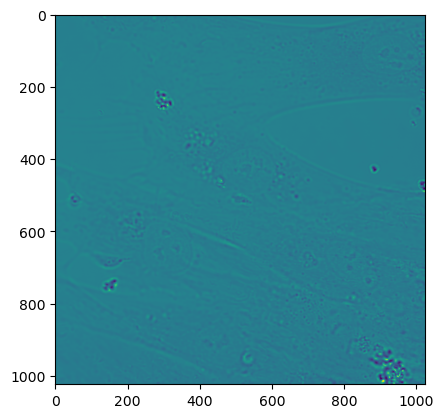

In [94]:
plt.imshow(train_data[0][0])

### Pytable

##### Create pytable (run only once)

See create_pytables.ipynb

### Adding data to pytable

In [99]:
import tables
import numpy as np

In [100]:
#def batch_write_to_pytables(data_list, table, batch_size=1000):
#    total_records = len(data_list)
#    for i in range(0, total_records, batch_size):
#        batch_data = data_list[i:i+batch_size]
#        table.append(batch_data)
#        table.flush()

#### Add train dataset

In [103]:
# Open an existing PyTable file or create a new one
with tables.open_file('/media/local-admin/lightmycells/thesis/code/pytables/stack/DIC_6_cubic/study_DIC_train_stack.pytable', mode='a') as h5file:

    # Access the desired group or table
    img_earray = h5file.root.img.data
    mask_earray = h5file.root.mask.data

    for record in train_data:
        record = np.expand_dims(record, axis=0)
        img_earray.append(record)

    for record in train_targets:
        record = np.expand_dims(record, axis=0)
        mask_earray.append(record)  

#### Add validation dataset

In [104]:
# Open an existing PyTable file or create a new one
with tables.open_file('/media/local-admin/lightmycells/thesis/code/pytables/stack/DIC_6_cubic/study_DIC_valid_stack.pytable', mode='a') as h5file:

    # Access the desired group or table
    img_earray = h5file.root.img.data
    mask_earray = h5file.root.mask.data

    for record in validation_data:
        record = np.expand_dims(record, axis=0)
        img_earray.append(record)

    for record in validation_targets:
        record = np.expand_dims(record, axis=0)
        mask_earray.append(record)  

#### Add test dataset

In [105]:
# Open an existing PyTable file or create a new one
with tables.open_file('/media/local-admin/lightmycells/thesis/code/pytables/stack/DIC_6_cubic/study_DIC_test_stack.pytable', mode='a') as h5file:

    # Access the desired group or table

    data_shape = test_data.shape
    shape_suffix = f"{data_shape[-2]}"  # Assuming the shape you're interested in is in the second-to-last dimension
    
    # Access the desired group or table
    img_earray = h5file.root.img[f'data_{shape_suffix}']
    mask_earray = h5file.root.mask[f'data_{shape_suffix}']
    
    # Iterate through your data and append it to the EArray
    for data_row in test_data:
        data_row = np.expand_dims(data_row, axis=0)
        img_earray.append(data_row)
        print(data_row.dtype)

    for data_row in test_targets:
        data_row = np.expand_dims(data_row, axis=0)
        mask_earray.append(data_row)
        print(data_row.dtype)

uint16
uint16


#### Check pytable structures

In [106]:
train_file = '/media/local-admin/lightmycells/thesis/code/pytables/stack/DIC_6_cubic/study_DIC_train_stack.pytable'
test_file = '/media/local-admin/lightmycells/thesis/code/pytables/stack/DIC_6_cubic/study_DIC_test_stack.pytable'
valid_file = '/media/local-admin/lightmycells/thesis/code/pytables/stack/DIC_6_cubic/study_DIC_valid_stack.pytable'

# Open the PyTable file
with tables.open_file(test_file, mode='r') as h5file:
    # Print the structure of the file
    print(h5file)

    # Access and print information about groups
    for group in h5file.walk_groups():
        print(f"Group: {group}")

    # Access and print information about arrays
    for array in h5file.walk_nodes(where='/', classname='Array'):
        print(f"Array: {array}")

/media/local-admin/lightmycells/thesis/code/pytables/stack/DIC/study_DIC_test_stack.pytable (File) ''
Last modif.: '2024-06-18T08:02:12+00:00'
Object Tree: 
/ (RootGroup) ''
/img (Group) 'Image data'
/img/data_1024 (EArray(1, 6, 1024, 1024)zlib(5)) ''
/img/data_1200 (EArray(0, 6, 1200, 1200)zlib(5)) ''
/img/data_1300 (EArray(0, 6, 1300, 1624)zlib(5)) ''
/img/data_2044 (EArray(0, 6, 2044, 2048)zlib(5)) ''
/img/data_2048 (EArray(0, 6, 2048, 2048)zlib(5)) ''
/img/data_512 (EArray(0, 6, 512, 512)zlib(5)) ''
/img/data_966 (EArray(0, 6, 966, 1296)zlib(5)) ''
/img/data_980 (EArray(0, 6, 980, 1016)zlib(5)) ''
/mask (Group) 'Mask data'
/mask/data_1024 (EArray(1, 4, 1024, 1024)zlib(5)) ''
/mask/data_1200 (EArray(0, 4, 1200, 1200)zlib(5)) ''
/mask/data_1300 (EArray(0, 4, 1300, 1624)zlib(5)) ''
/mask/data_2044 (EArray(0, 4, 2044, 2048)zlib(5)) ''
/mask/data_2048 (EArray(0, 4, 2048, 2048)zlib(5)) ''
/mask/data_512 (EArray(0, 4, 512, 512)zlib(5)) ''
/mask/data_966 (EArray(0, 4, 966, 1296)zlib(5)) ''

In [107]:
train_targets.shape

(8, 4, 1024, 1024)

In [108]:
train_data.shape

(8, 6, 1024, 1024)

In [462]:
tables.file._open_files.close_all()

#### Old pytable (irrelevant)

In [463]:
# Define the shape of your image and mask data
#img_shape = train_data[0].shape 
#mask_shape = train_targets[0].shape

#numpixels
#pixel_list = []
#for target in train_targets:
#     pixel_list.append(np.count_nonzero(target))
#pixel_array = np.array(pixel_list)
#pixel_array = np.reshape(pixel_array, (len(train_targets), 1))

## Verify the shapes of the loaded data
#print("Image data shape:", train_data.shape)
#print("Mask data shape:", train_data.shape)

##data_shape
#data_shape = train_data.shape[0]

#pytable_fname = '/media/local-admin/galaxy/lightmycells_storage/Study_patches_s/tools/pytables/train/study_patches_s_Study_24_train.pytable'
## Create PyTable instance
#custom_pytable = CustomPyTable(pytable_fname, img_shape, mask_shape)

## Create PyTable file and populate with image and mask data
#custom_pytable.create_pytable(train_data, train_targets, pixel_array, data_shape)

In [464]:
#img_shape = validation_data[0].shape 
#mask_shape = validation_targets[0].shape

#numpixels
#pixel_list = []
#for target in validation_targets:
#     pixel_list.append(np.count_nonzero(target))
#pixel_array = np.array(pixel_list)
#pixel_array = np.reshape(pixel_array, (len(validation_targets), 1))

## Verify the shapes of the loaded data
#print("Image data shape:", validation_data.shape)
#print("Mask data shape:", validation_data.shape)

##data_shape
#data_shape = validation_data.shape

#pytable_fname = '/media/local-admin/galaxy/lightmycells_storage/Study_patches_s/tools/pytables/valid/study_patches_s_Study_24_valid.pytable'
## Create PyTable instance
#custom_pytable = CustomPyTable(pytable_fname, img_shape, mask_shape)

## Create PyTable file and populate with image and mask data
#custom_pytable.create_pytable(validation_data, validation_targets, pixel_array, data_shape)

In [465]:
#img_shape = test_data[0].shape 
#mask_shape = test_targets[0].shape

##numpixels
#pixel_list = []
#for target in test_targets:
#     pixel_list.append(np.count_nonzero(target))
#pixel_array = np.array(pixel_list)
#pixel_array = np.reshape(pixel_array, (len(test_targets), 1))

## Verify the shapes of the loaded data
#print("Image data shape:", test_data.shape)
#print("Mask data shape:", test_data.shape)

##data_shape
#data_shape = test_data.shape

#pytable_fname = '/media/local-admin/galaxy/lightmycells_storage/Study_patches_s/tools/pytables/test/study_patches_s_Study_24_test.pytable'
## Create PyTable instance
#custom_pytable = CustomPyTable(pytable_fname, img_shape, mask_shape)

## Create PyTable file and populate with image and mask data
#custom_pytable.create_pytable(test_data, test_targets, pixel_array, data_shape)